# 7.Dyna-Q 算法
**强化学习算法**有两个重要的评价指标：一个是算法收敛后的策略在初始状态下的**期望回报**，另一个是**样本复杂度**

| 类型                           | 特点                                         | 样本复杂度             | 策略期望回报               | 原因                                       |
|--------------------------------|--------------------------------------------|------------------------|----------------------------|--------------------------------------------|
| **基于模型的强化学习算法**     | 具有环境模型，智能体可以与模型交互          | 样本复杂度较低         | 收敛后的策略期望回报可能不如无模型算法 | 通过与环境模型交互，减少了对真实环境样本的需求，但模型可能不准确 |
| **无模型的强化学习算法**       | 没有环境模型，完全依赖真实环境进行交互      | 样本复杂度较高         | 收敛后的策略期望回报通常较高     | 无需依赖模型，直接与真实环境互动，策略可能更精确        |


相较之前介绍的两种动态规划算法：**策略迭代** 和 **价值迭代**
**Dyna-Q 算法（Dynamic-Q表）**也是非常基础的**基于模型的强化学习算法**，不过其环境模型通过**采样数据估计**得到：

1. **Dyna-Q** 使用一种叫做 **Q-planning** 的方法来基于模型生成一些模拟数据，然后用模拟数据和真实数据一起改进策略
2. 在每次与环境进行交互执行一次 Q-learning 之后，Dyna-Q 会做n次 Q-planning
3. Q-planning 的次数是一个事先可以选择的超参数，当其为 0 时退化为普通的 Q-learning

导入相关库

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time

### 悬崖漫步环境 :
仍在 **悬崖漫步环境** 下学习体验算法

In [2]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow  # 行
        self.ncol = ncol  # 列
        self.x = 0  # 初始化智能体位置的横坐标
        self.y = self.nrow - 1  # 初始化智能体位置的纵坐标  坐标系原点(0,0)

    def step(self, action):  # 改变智能体位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x  # 用一维数值编号代表位置状态
        reward = -1  # 短路径
        done = False
        
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:  # 确定在悬崖
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

![示意图](images/悬崖环境代码定义示意图.jpg)

## Dyna-Q算法实现
在 Q-learning 的代码上进行简单修改，实现 Dyna-Q 的主要代码：
最主要的修改是加入了环境模型 **model**，用一个字典表示，每次在真实环境中收集到新的数据，就把它加入 **字典**（若数据已经存在，便不会再一次进行添加）


算法代码：

In [3]:
class DynaQ:
    """ DynaQ算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_planning, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  # 1次Q-learning n次Q-planning
        self.model = dict()  # 环境模型（字典类型存储信息）

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)    # 1次 Q-learning
        self.model[(s0, a0)] = r, s1      # 将数据添加到模型中
        for _ in range(self.n_planning):  # n次 Q-planning循环,一次抽取一个
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

训练函数：

In [4]:
def DynaQ_CliffWalking(n_planning):
    # 环境初始化
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    # 超参数设置 
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    # 智能体定义 
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    
    num_episodes = 300  # 智能体在环境中运行多少条序列
    
    #--------------------------------------------------------------------------------------复用前一节Q-learning
    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)  
                    next_state, reward, done = env.step(action)
                    episode_return += reward  
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    #---------------------------------------------------------------------------------------复用 
    return return_list

可视化 Q-planning 步数对结果的影响：

In [5]:
np.random.seed(0)
random.seed(0)

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3153.77it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1871.45it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 402.89it/s, episode=300, return=-13.400]


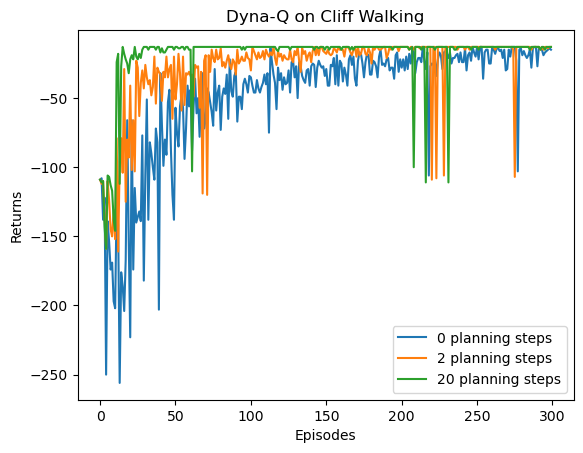

In [6]:
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
# --最好不要分开为两个独立代码单元-- 
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

可见，在上述悬崖漫步环境中，**Q-planning** 步数越大则算法收敛越快
但注意，并不是在所有的环境中都是。这取决于环境是否是确定性的，以及环境模型的精度
上述构建的悬崖漫步环境中，状态的转移是完全确定性的，构建的环境模型的精度是最高的，所以可以通过增加 Q-planning 步数来直接降低算法的样本复杂度。

**Q-planning** 方法虽然在以上自定义的简单环境中获得了很好的效果
但如果环境比较复杂(状态是连续的，或者状态转移是随机的而不是决定性的) 如何准确的学习一个模型？
**基于模型的强化学习算法** 能否应用于这些环境并获得比 **无模型的强化学习** 更好的效果呢...

- [模型预测控制MPC](../RL_Advanced_Algorithms/19.1_2_模型预测控制MPC.ipynb) 
- [基于模型的策略优化MBPO](../RL_Advanced_Algorithms/20.基于模型的策略优化MBPO.ipynb) 